# BERTopic

In [1]:
import sys
sys.path.insert(0, '..')
from utils.preprocesamiento import df_to_list

In [26]:
op_left, op_right = 'Producir el alimento', 'Resguardar tradiciones'

In [2]:
import pandas as pd
from utils.cargar import df_caso
from utils.preprocesamiento import process_df, procesar_adela

caso = 'adela'
df = df_caso(caso)

df = procesar_adela(df)
df = df[df['opt_left'] == 'Producir el alimento contra déficit vitamínico']

df = process_df(df,'comment','sel',verbose=True)

train_indices = pd.read_csv('../utils/splits/train_indices_{}.csv'.format(caso), header=None)[0].tolist()
test_indices = pd.read_csv('../utils/splits/test_indices_{}.csv'.format(caso), header=None)[0].tolist()
print("Partición train-test cargada")

df_train = df.iloc[train_indices]
df_test = df.iloc[test_indices]

26 rows found with non string elements for column comment (0.40%)
Deleting 685 columns for which max target value is over 7 (10.58%)
5761 available rows after processing
Partición train-test cargada


Guardando la partición train-test

In [3]:
from utils.preprocesamiento import StemmerTokenizer

tokenizador = StemmerTokenizer(stem=False,rmv_punctuation=True)

docs_train = df_to_list(df_train,'comment',tokenizador)
docs_test = df_to_list(df_test, 'comment',tokenizador)

## BERTopic algorithm

In [4]:
from IPython.display import Image, display
display(Image(url='https://maartengr.github.io/BERTopic/algorithm/modularity.svg'))

In [5]:
%%capture
from bertopic import BERTopic

In [6]:
model = BERTopic(language="spanish",min_topic_size=10,nr_topics=25,calculate_probabilities=True)

In [7]:
%%time
topics, probs = model.fit_transform(docs_train)

CPU times: user 2min 4s, sys: 4.58 s, total: 2min 8s
Wall time: 1min 10s


In [8]:
model.get_topic_freq().head(5)

,Topic,Count
6,0,1054
2,1,896
4,-1,812
5,2,795
0,3,435


In [9]:
model.get_topic(0)[:10]

[('vitamina', 0.0441807943447517),
 ('déficit', 0.03649062856070358),
 ('vitamínico', 0.031834163279054965),
 ('alimento', 0.025447164345069283),
 ('tradiciones', 0.02527269464684898),
 ('importante', 0.022359331267448802),
 ('producir', 0.021074324094486892),
 ('vitaminas', 0.019794584369329148),
 ('deficit', 0.019166997247505556),
 ('pueblo', 0.018956926576061704)]

Topicos para algunos documentos

In [10]:
for i, t in enumerate(model.topics_[:10]):
    print('Tópico {}:\ttexto: {}'.format(t,docs_train[i]))

Tópico 3:	texto: Adela debería priorizar salud personas alguna creencia grupo pequeño personas
Tópico 3:	texto: Dado Adela quiere utilizar fruto tradicional pueblo originario cuál esforzado cultivar mantener vigente debería respetar condiciones pueblo originario acepta uso fruto encargados hacerlo subsistir
Tópico 6:	texto: Si bien aún proyecto obligacion considerar opinión pueblos originarios demasía importante considerar opinión respeto cultura cosmovisión Lamenetablemente existe disgusto parte últimos proyecto existirá conflicto fututo hora producir producto Lo prudente realizar estudio baja escala implementando producción alimento compromiso incluir miembros comunidades indígenas llegar acuerdos conjunto
Tópico 1:	texto: Debe priorizar producción alimento pues trata deficiencia salud puede llegar generar problemas graves si tratan todas formas seguiría tratando lograr acuerdo pueblo originario si logra terminaría priorizando producción alimento
Tópico 4:	texto: Considero debería po

### Inferencia en conjunto test

In [11]:
string = 'Aun considero necesario resguardar mas tradiciones identitarias embargo producir alimento podría ayudar muchas personas entonces debería existir diálogo ambas partes llegar mejor solución'

model.transform([string])

([1],
 array([[7.22625931e-04, 5.20370313e-01, 5.58261677e-03, 3.81551252e-04,
         3.68537506e-03, 3.55576624e-04, 1.35068002e-02, 2.07828588e-04,
         4.98462932e-02, 3.46375629e-02, 1.76650222e-04, 1.08948587e-02,
         1.00369434e-02, 8.92226582e-03, 2.41956648e-02, 9.69277862e-03,
         1.16559050e-02, 1.16697920e-02, 1.18743119e-02, 3.45872656e-03,
         4.07446757e-03, 9.40332773e-03, 7.87021857e-03, 1.21457278e-02]]))

In [12]:
output = model.transform(df_to_list(df_test.iloc[:3],'comment',tokenizador))

Imprimiendo los embeddings

In [13]:
output[1]

array([[2.48227831e-02, 1.64108244e-02, 1.32402910e-02, 4.04241711e-01,
        4.66547248e-03, 1.20663407e-02, 1.19170359e-02, 5.96715173e-03,
        2.02261543e-02, 1.48959180e-02, 7.53811917e-03, 4.73727507e-03,
        4.60841216e-03, 4.41209530e-03, 9.82756902e-03, 5.16923794e-03,
        4.84228796e-03, 4.96731102e-03, 4.85895764e-03, 4.58077923e-03,
        4.91325232e-03, 4.50120648e-03, 5.41808766e-03, 5.13430012e-03],
       [2.00682162e-02, 9.40615437e-02, 1.35736964e-01, 1.11752653e-02,
        1.83172603e-02, 8.95693814e-03, 3.96460592e-02, 5.58247795e-03,
        9.29648693e-02, 6.82740408e-02, 4.88851531e-03, 2.09973505e-02,
        1.99568977e-02, 1.86460274e-02, 4.43329190e-02, 2.28192966e-02,
        2.16396069e-02, 2.21387163e-02, 2.20593546e-02, 1.77400710e-02,
        1.97459646e-02, 1.92237570e-02, 2.69656572e-02, 2.37428664e-02],
       [2.21669756e-09, 3.53207509e-02, 2.08635294e-05, 1.22191068e-09,
        1.76042809e-06, 1.08075293e-09, 3.53595291e-02, 6.4818

In [14]:
output[0]

[3, 2, -1]

Visualización

In [15]:
model.visualize_topics()

Podemos relacionar tópicos con palabras en específico

In [16]:
target = 'integridad'

topic_num = 5

similar_topics, similarity = model.find_topics(target, top_n=topic_num)
similar_topics

[13, 21, 12, 8, 11]

In [17]:
similarity

[0.5150720836291274,
 0.4231761312192151,
 0.3239559199815657,
 0.3171026022165045,
 0.3162054862783472]

In [18]:
data = [[] for _ in range(topic_num)]
max_w = 5

for i, t in enumerate(similar_topics):
    data[i].append(t)
    data[i].append(similarity[i])
    data[i] += [tup[0] for tup in model.get_topic(t)[:max_w]]

In [19]:
from utils.exploracion import print_table_md

print("Tópicos relevantes para concepto: {}".format(target))

headers = ['Tópico','Probabilidad'] + ['Palabra {}'.format(i+1) for i in range(max_w)]

print_table_md(headers, data)

Tópicos relevantes para concepto: integridad


| Tópico | Probabilidad | Palabra 1 | Palabra 2 | Palabra 3 | Palabra 4 | Palabra 5 |
| --- | --- | --- | --- | --- | --- | --- |
| 13 | 0.5150720836291274 | mitad | mismo | lo | esos | repitió |
| 21 | 0.4231761312192151 | postura | mantengo | manteniendo | internet | modifico |
| 12 | 0.3239559199815657 | opinion | opinión | misma | mi | grupo |
| 8 | 0.3171026022165045 | proyecto | tradiciones | identitarias | resguardar | llevar |
| 11 | 0.3162054862783472 | ambas | partes | acuerdo | dos | llegar |


### Analizando correlaciones con selección de postura

Por el momento binarizando la postura

In [21]:
df.loc[(df['sel']==2) | (df['sel']==3),'sel'] = 1
df.loc[(df['sel']==4) | (df['sel']==5),'sel'] = 6

In [24]:
output_sel1 = model.transform(df_to_list(df_test[df_test['sel']==1],'comment',tokenizador))

In [25]:
output_sel6 = model.transform(df_to_list(df_test[df_test['sel']==6],'comment',tokenizador))

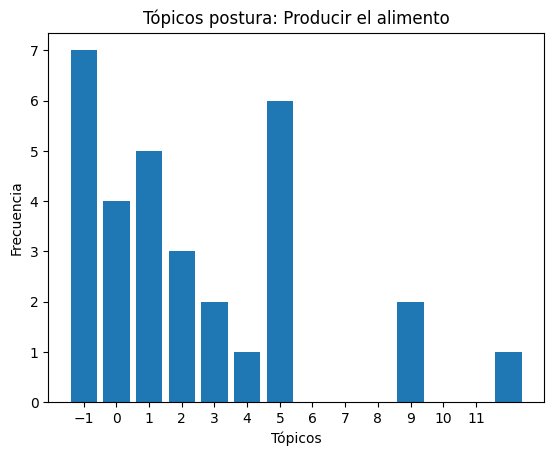

In [37]:
import matplotlib.pyplot as plt

def get_element_frequency(input_list):
    frequency_dict = {}
    for element in input_list:
        if element in frequency_dict:
            frequency_dict[element] += 1
        else:
            frequency_dict[element] = 1
    return frequency_dict

counts = get_element_frequency(output_sel1[0])

# Switching to the OO-interface. You can do all of this with "plt" as well.
fig, ax = plt.subplots()

keys = counts.keys()
values = counts.values()

plt.bar(keys, values)

custom_ticks = list(range(-1,max(output_sel1[0])))
plt.xticks(custom_ticks)

plt.xlabel('Tópicos')
plt.ylabel('Frecuencia')
plt.title('Tópicos postura: {}'.format(op_left))

plt.show()

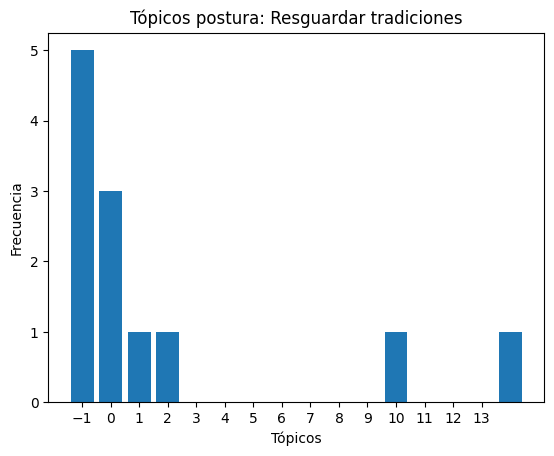

In [38]:
counts = get_element_frequency(output_sel6[0])

# Switching to the OO-interface. You can do all of this with "plt" as well.
fig, ax = plt.subplots()

keys = counts.keys()
values = counts.values()

plt.bar(keys, values)

custom_ticks = list(range(-1,max(output_sel6[0])))
plt.xticks(custom_ticks)

plt.xlabel('Tópicos')
plt.ylabel('Frecuencia')
plt.title('Tópicos postura: {}'.format(op_right))

plt.show()

Guardando el modelo

In [16]:
model.save("modelos/BT-{}.bertopic".format(caso))

Para cargar:

`my_model = BERTopic.load("modelos/BT-caso")`